In [2]:
import numpy as np
import re
import cv2
import imutils
from imutils.contours import sort_contours
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf

import io
import os
import scipy.misc
import six
import time
import glob
from IPython.display import display

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

import warnings
warnings.filterwarnings('ignore') 

%matplotlib inline

In [3]:
base_path = 'D:/Study/DataScience/ObjectDetection/Tensorflow/models/research/object_detection/pole_fixture_detector'
model_path = os.path.join(base_path, 'fine_tuned_model/saved_model/')
labelmap_path = os.path.join(base_path,'labelmap_polefixture2.pbtxt')

In [21]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [24]:
model = tf.saved_model.load(f'D:/Study/DataScience/ObjectDetection/Tensorflow/models/research/object_detection/pole_fixture_detector\\fine_tuned_model/saved_model')

In [26]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
    if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

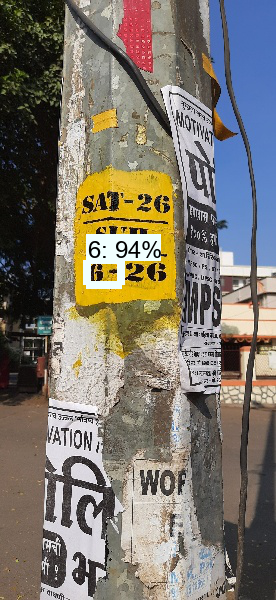

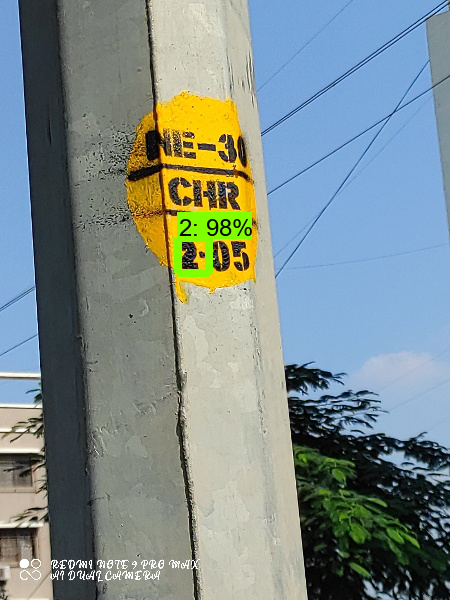

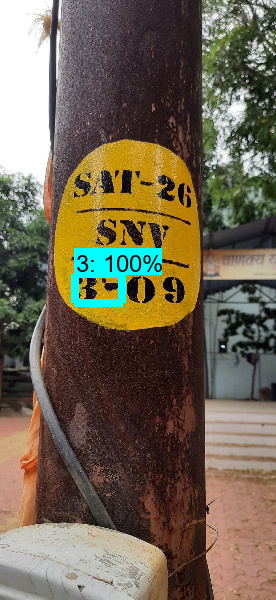

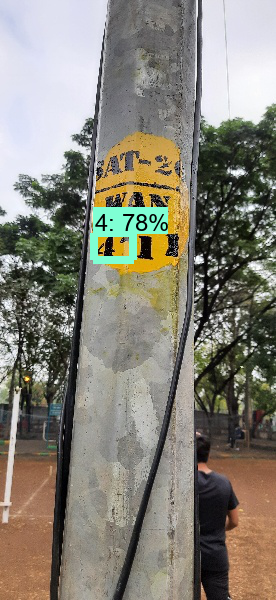

In [29]:
for image_path in glob.glob('D:/Study/DataScience/ObjectDetection/Tensorflow/models/research/object_detection/pole_fixture_detector/*.jpg'):
    image_np = load_image_into_numpy_array(image_path)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
    display(Image.fromarray(image_np))

In [30]:
output_dict

{'detection_anchor_indices': array([  3.,   3.,   3.,   3., 951., 902., 615., 633., 186., 503., 956.,
        447., 712., 589., 666., 661., 774., 711.,  27., 666., 178., 274.,
        927., 947.,  24., 927., 265., 651., 701., 266., 843., 456., 232.,
        731., 712., 615., 579., 371., 186., 633., 633.,  42., 711., 824.,
        170., 176., 633., 186., 109., 864., 354., 628., 229., 266., 449.,
        233., 447., 926., 145., 751., 503., 858., 823., 503., 503., 615.,
        305., 140., 186., 550., 929., 447., 447., 649.,  55., 669., 615.,
        266., 507., 799., 549., 589., 711., 560., 142., 565., 661., 589.,
         27., 823., 274., 589., 930.,  88., 488., 230., 823.,  89., 195.,
        661., 763.,  27., 178., 883., 853., 824., 711., 656., 712., 661.,
        843.,  27., 565., 628., 590., 327., 941., 266., 832., 178., 355.,
        930., 864., 317., 274., 363., 701., 930., 345., 274., 565., 205.,
        221., 947., 853., 398.,  43., 947., 758., 480., 843., 823., 176.,
        95